# BiomeFUN 
# Stoichiometric Modelling

This notebook contains the exercises covered in the lecture on Stoichiometric Metabolic Modelling by Timmy Paez Watson. Some lines of code have been removed to be completed during the lecture. For access to the complete notebooks, please go to: https://tp-watson.github.io/Teaching-Site/materials/

## Model simulations with COBRA

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from cobra import Model, Reaction, Metabolite


# Load the S matrix
S_mat = pd.read_excel('2_Basic_model.xlsx', sheet_name='Model', index_col=0)
mets = list(S_mat.index)
rxns = list(S_mat.T.index)

# Create an empty COBRA model
model = Model('simple_model')

# Generate metabolites and reactions using the COBRA functions
metabolites = {met: Metabolite(met, name=met, compartment='c') for met in mets}

# For reactions you need the S matrix info
for rxn_id in rxns:
    rxn = Reaction(rxn_id)
    stoich = S_mat[rxn_id]
    for met_id, coeff in stoich.items():
        if coeff != 0:
            rxn.add_metabolites({metabolites[met_id]: coeff})
    model.add_reactions([rxn])
    

In [3]:
for rxn in model.reactions:
    print(rxn.id, ":", rxn.reaction)

v2 : G6P --> 2 Pyr
v3 : Mal + Pyr --> CO2 + Cit
v4 : Cit --> CO2 + aKG
v5 : aKG --> CO2 + Mal
v6 : CO2 + Pyr --> Mal
v7 : Mal --> 
v8 : CO2 --> 
v9 : Pyr --> CO2


### Check for blocked reactions

In [5]:
from cobra.flux_analysis import find_blocked_reactions

blocked = find_blocked_reactions(model)
blocked

['v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9']

### Find the issue and solve it

In [7]:
# Load the S matrix
S_mat = pd.read_excel('2_Basic_model.xlsx', sheet_name='Model_complete', index_col=0)
mets = list(S_mat.index)
rxns = list(S_mat.T.index)

# Create an empty COBRA model
model = Model('simple_model')

# Generate metabolites and reactions using the COBRA functions
metabolites = {met: Metabolite(met, name=met, compartment='c') for met in mets}

# For reactions you need the S matrix info
for rxn_id in rxns:
    rxn = Reaction(rxn_id)
    stoich = S_mat[rxn_id]
    for met_id, coeff in stoich.items():
        if coeff != 0:
            rxn.add_metabolites({metabolites[met_id]: coeff})
    model.add_reactions([rxn])

blocked = find_blocked_reactions(model)
blocked

[]

## Solve the model with Flux Balance Analysis
Optimize for ethanol producion

In [9]:
# 1) set bounds for v1
model.reactions.v1.bounds = (0.0, 1.0)

# 2) set the objective to v9
model.objective = "v9"

# 3) optimize
sol = model.optimize()
print("status:", sol.status)

# 4) peek at fluxes (only the non-zeros)
fluxes = sol.fluxes
print(fluxes[fluxes != 0])

status: optimal
v1    1.0
v2    1.0
v8    2.0
v9    2.0
Name: fluxes, dtype: float64


## Scan two oposing solutions

Generate the pareto front between ethanol and malate production. Keep glucose uptake (v1) constant.

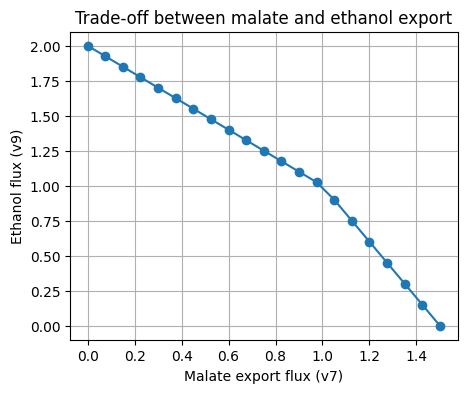

In [11]:
# reset v1 bounds
model.reactions.v1.bounds = (0.0, 1.0)

# objective = ethanol export (v9)
model.objective = "v9"

orig_bounds = model.reactions.v7.bounds

# sweep values for malate export
targets = np.linspace(0, 1.5, 21)   # from 0 to 2 in 21 steps

mal_fluxes = []
ethanol_fluxes = []

for t in targets:
    model.reactions.v7.bounds = (t, t)
    
    sol = model.optimize()
    if sol.status == "optimal":
        mal_fluxes.append(sol.fluxes["v7"])
        ethanol_fluxes.append(sol.fluxes["v9"])
    else:
        mal_fluxes.append(np.nan)
        ethanol_fluxes.append(np.nan)

# restore original bounds (optional)
model.reactions.v7.bounds = orig_bounds

# plot ethanol vs malate
plt.figure(figsize=(5,4))
plt.plot(mal_fluxes, ethanol_fluxes, marker="o")
plt.xlabel("Malate export flux (v7)")
plt.ylabel("Ethanol flux (v9)")
plt.title("Trade-off between malate and ethanol export")
plt.grid(True)
plt.show()